# Optimization Overview

![Optimization Overview](img/model-optimization-overview.png)

# Train Model with CPU

In [1]:
import tensorflow as tf
from tensorflow.python.client import timeline
import pylab
import numpy as np
import os

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

tf.logging.set_verbosity(tf.logging.INFO)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Reset TensorFlow Graph
Useful in Jupyter Notebooks

In [2]:
tf.reset_default_graph()

## Create TensorFlow Session

In [3]:
sess = tf.Session()
print(sess)

### Load Model Training and Test/Validation Data 


In [4]:
num_samples = 100000

[0.96528274 0.94759524 0.22383523 ... 0.5701787  0.14670466 0.5574794 ]
[0.38724757 0.40706604 0.32637615 ... 0.35807499 0.3328473  0.35447101]


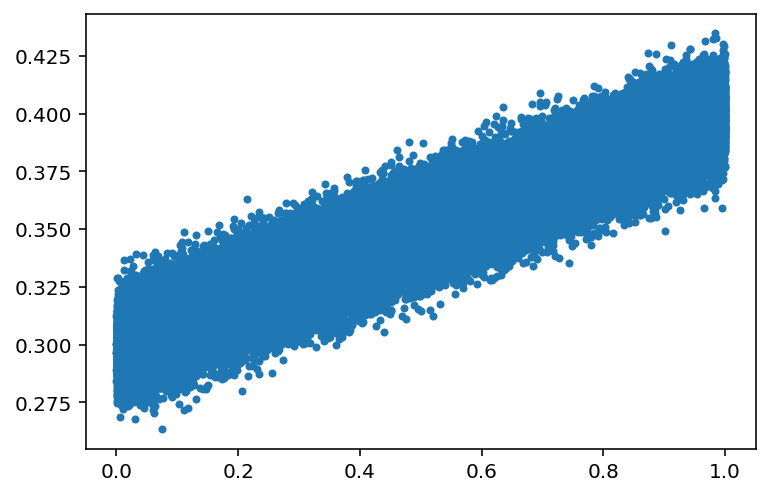

In [5]:
import numpy as np

x_train = np.random.rand(num_samples).astype(np.float32)
print(x_train)

noise = np.random.normal(scale=0.01, size=len(x_train))

y_train = x_train * 0.1 + 0.3 + noise
print(y_train)

pylab.plot(x_train, y_train, '.')

[0.88350475 0.31091717 0.9429351  ... 0.5535146  0.04712464 0.01313777]
[0.37393607 0.345041   0.39522013 ... 0.34706197 0.29856482 0.31138153]


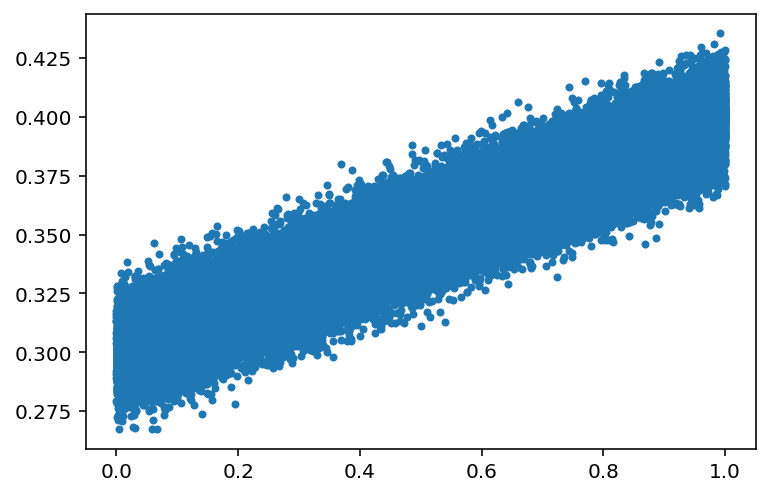

In [6]:
import pylab

x_test = np.random.rand(len(x_train)).astype(np.float32)
print(x_test)

noise = np.random.normal(scale=.01, size=len(x_train))

y_test = x_test * 0.1 + 0.3 + noise
print(y_test)

pylab.plot(x_test, y_test, '.')

In [7]:
with tf.device("/cpu:0"):
    W = tf.get_variable(shape=[], name='weights')
    print(W)

    b = tf.get_variable(shape=[], name='bias')
    print(b)

    x_observed = tf.placeholder(shape=[None], 
                                dtype=tf.float32, 
                                name='x_observed')
    print(x_observed)

    y_pred = W * x_observed + b
    print(y_pred)

Instructions for updating:
Colocations handled automatically by placer.
<tf.Variable 'weights:0' shape=() dtype=float32_ref>
<tf.Variable 'bias:0' shape=() dtype=float32_ref>
Tensor("x_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Tensor("add:0", shape=(?,), dtype=float32, device=/device:CPU:0)


In [8]:
learning_rate = 0.025

with tf.device("/cpu:0"):
    y_observed = tf.placeholder(shape=[None], dtype=tf.float32, name='y_observed')
    print(y_observed)

    loss_op = tf.reduce_mean(tf.square(y_pred - y_observed))
    optimizer_op = tf.train.GradientDescentOptimizer(learning_rate)
    
    train_op = optimizer_op.minimize(loss_op)  

    print("Loss Scalar: ", loss_op)
    print("Optimizer Op: ", optimizer_op)
    print("Train Op: ", train_op)

Tensor("y_observed:0", shape=(?,), dtype=float32, device=/device:CPU:0)
Loss Scalar:  Tensor("Mean:0", shape=(), dtype=float32, device=/device:CPU:0)
Optimizer Op:  <tensorflow.python.training.gradient_descent.GradientDescentOptimizer object at 0x7ffb9809a7b8>
Train Op:  name: "GradientDescent"
op: "NoOp"
input: "^GradientDescent/update_weights/ApplyGradientDescent"
input: "^GradientDescent/update_bias/ApplyGradientDescent"
device: "/device:CPU:0"



## Randomly Initialize Variables (Weights and Bias)
The goal is to learn more accurate Weights and Bias during training.

In [9]:
with tf.device("/cpu:0"):
    init_op = tf.global_variables_initializer()
    print(init_op)

name: "init"
op: "NoOp"
input: "^weights/Assign"
input: "^bias/Assign"
device: "/device:CPU:0"



In [10]:
sess.run(init_op)
print("Initial random W: %f" % sess.run(W))
print("Initial random b: %f" % sess.run(b))

Initial random W: -1.199659
Initial random b: -0.635167


## View Accuracy of Pre-Training, Initial Random Variables
We want this to be close to 0, but it's relatively far away.  This is why we train!

In [11]:
def test(x, y):
    return sess.run(loss_op, feed_dict={x_observed: x, y_observed: y})

In [12]:
test(x_test, y_test)

2.6511357

## Setup Loss Summary Operations for Tensorboard

In [13]:
loss_summary_scalar_op = tf.summary.scalar('loss', loss_op)
loss_summary_merge_all_op = tf.summary.merge_all()

In [14]:
train_summary_writer = tf.summary.FileWriter('./linear_model/logs/cpu/train/', 
                                            graph=tf.get_default_graph())

test_summary_writer = tf.summary.FileWriter('./linear_model/logs/cpu/test/',
                                            graph=tf.get_default_graph())

## Train Model

In [15]:
%%time

from tensorflow.python.client import timeline

with tf.device("/cpu:0"):
    run_metadata = tf.RunMetadata()
    max_steps = 401
    for step in range(max_steps):
        if (step < max_steps - 1):
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train})
        else:  
            test_summary_log, _ = sess.run([loss_summary_merge_all_op, loss_op], feed_dict={x_observed: x_test, y_observed: y_test})
            train_summary_log, _ = sess.run([loss_summary_merge_all_op, train_op], feed_dict={x_observed: x_train, y_observed: y_train}, 
                                            options=tf.RunOptions(trace_level=tf.RunOptions.SOFTWARE_TRACE), 
                                            run_metadata=run_metadata)

            trace = timeline.Timeline(step_stats=run_metadata.step_stats)    
            with open('timeline-cpu.json', 'w') as trace_file:
                trace_file.write(trace.generate_chrome_trace_format(show_memory=True))

        if step % 10 == 0:
            print(step, sess.run([W, b]))
            train_summary_writer.add_summary(train_summary_log, step)
            train_summary_writer.flush()
            test_summary_writer.add_summary(test_summary_log, step)
            test_summary_writer.flush()

0 [-1.1545748, -0.5559031]
10 [-0.82892996, 0.0038383715]
20 [-0.6507535, 0.28978837]
30 [-0.549477, 0.4336657]
40 [-0.48843214, 0.5038907]
50 [-0.44856107, 0.53600156]
60 [-0.41995463, 0.54845494]
70 [-0.39745668, 0.550834]
80 [-0.3783803, 0.54811263]
90 [-0.36132157, 0.5428705]
100 [-0.34554338, 0.5364432]
110 [-0.33065537, 0.52952063]
120 [-0.3164473, 0.5224575]
130 [-0.30280295, 0.51543397]
140 [-0.28965512, 0.50854003]
150 [-0.27696222, 0.50181895]
160 [-0.2646963, 0.49528974]
170 [-0.25283659, 0.488959]
180 [-0.24136634, 0.48282695]
190 [-0.230271, 0.4768905]
200 [-0.21953747, 0.47114512]
210 [-0.20915344, 0.46558556]
220 [-0.19910733, 0.4602062]
230 [-0.18938799, 0.45500147]
240 [-0.17998473, 0.4499658]
250 [-0.17088726, 0.44509384]
260 [-0.1620856, 0.44038025]
270 [-0.15357012, 0.43581986]
280 [-0.1453315, 0.43140775]
290 [-0.13736075, 0.42713907]
300 [-0.12964918, 0.4230092]
310 [-0.12218833, 0.41901362]
320 [-0.11497007, 0.41514796]
330 [-0.1079865, 0.41140792]
340 [-0.101229

(0, 1.0)

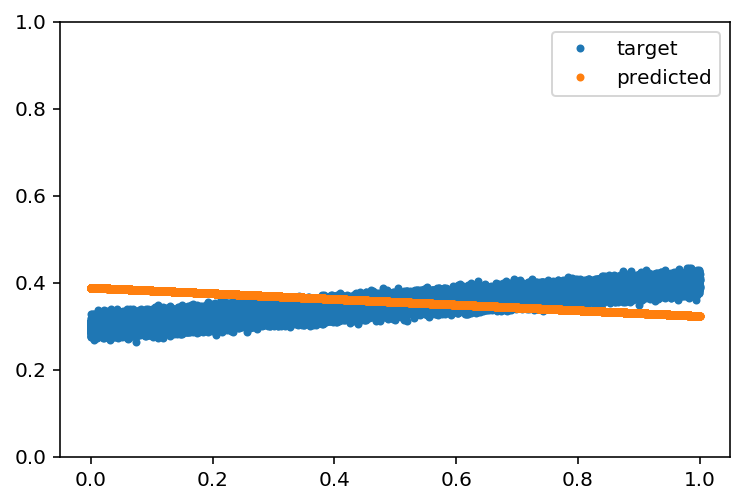

In [16]:
pylab.plot(x_train, y_train, '.', label="target")
pylab.plot(x_train, sess.run(y_pred, 
                             feed_dict={x_observed: x_train, 
                                        y_observed: y_train}), 
           ".", 
           label="predicted")
pylab.legend()
pylab.ylim(0, 1.0)

## View Loss Summaries in Tensorboard
Navigate to the **`Scalars`** and **`Graphs`** tab in TensorBoard

## Save Graph For Optimization
We will use this later.

In [17]:
import os
checkpoint_base_path = './linear_model/cpu/checkpoint'

saver = tf.train.Saver()

graph_model_path = '%s/graph.pb' % checkpoint_base_path
print(graph_model_path)

os.makedirs(checkpoint_base_path, exist_ok=True)

tf.train.write_graph(sess.graph_def, 
                     '.', 
                     graph_model_path,
                     as_text=False) 


checkpoint_model_path = '%s/model.ckpt' % checkpoint_base_path
saver.save(sess, 
           save_path=checkpoint_model_path)

print(checkpoint_model_path)

./linear_model/cpu/checkpoint/graph.pb
./linear_model/cpu/checkpoint/model.ckpt


In [18]:
os.listdir(checkpoint_base_path)

['model.ckpt.meta',
 'model.ckpt.index',
 'model.ckpt.data-00000-of-00001',
 'checkpoint',
 'graph.pb']

In [19]:
sess.close()

In [20]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))

In [21]:
output_dot_path='./graph_cpu.dot'
convert_graph_to_dot(input_graph=graph_model_path, output_dot=output_dot_path, is_input_graph_binary=True)

Created dot file './graph_cpu.dot' for graph './linear_model/cpu/checkpoint/graph.pb'.


In [22]:
%%bash -s "$output_dot_path"

dot -T png $1 \
    -o ./graph_cpu.png > a.out

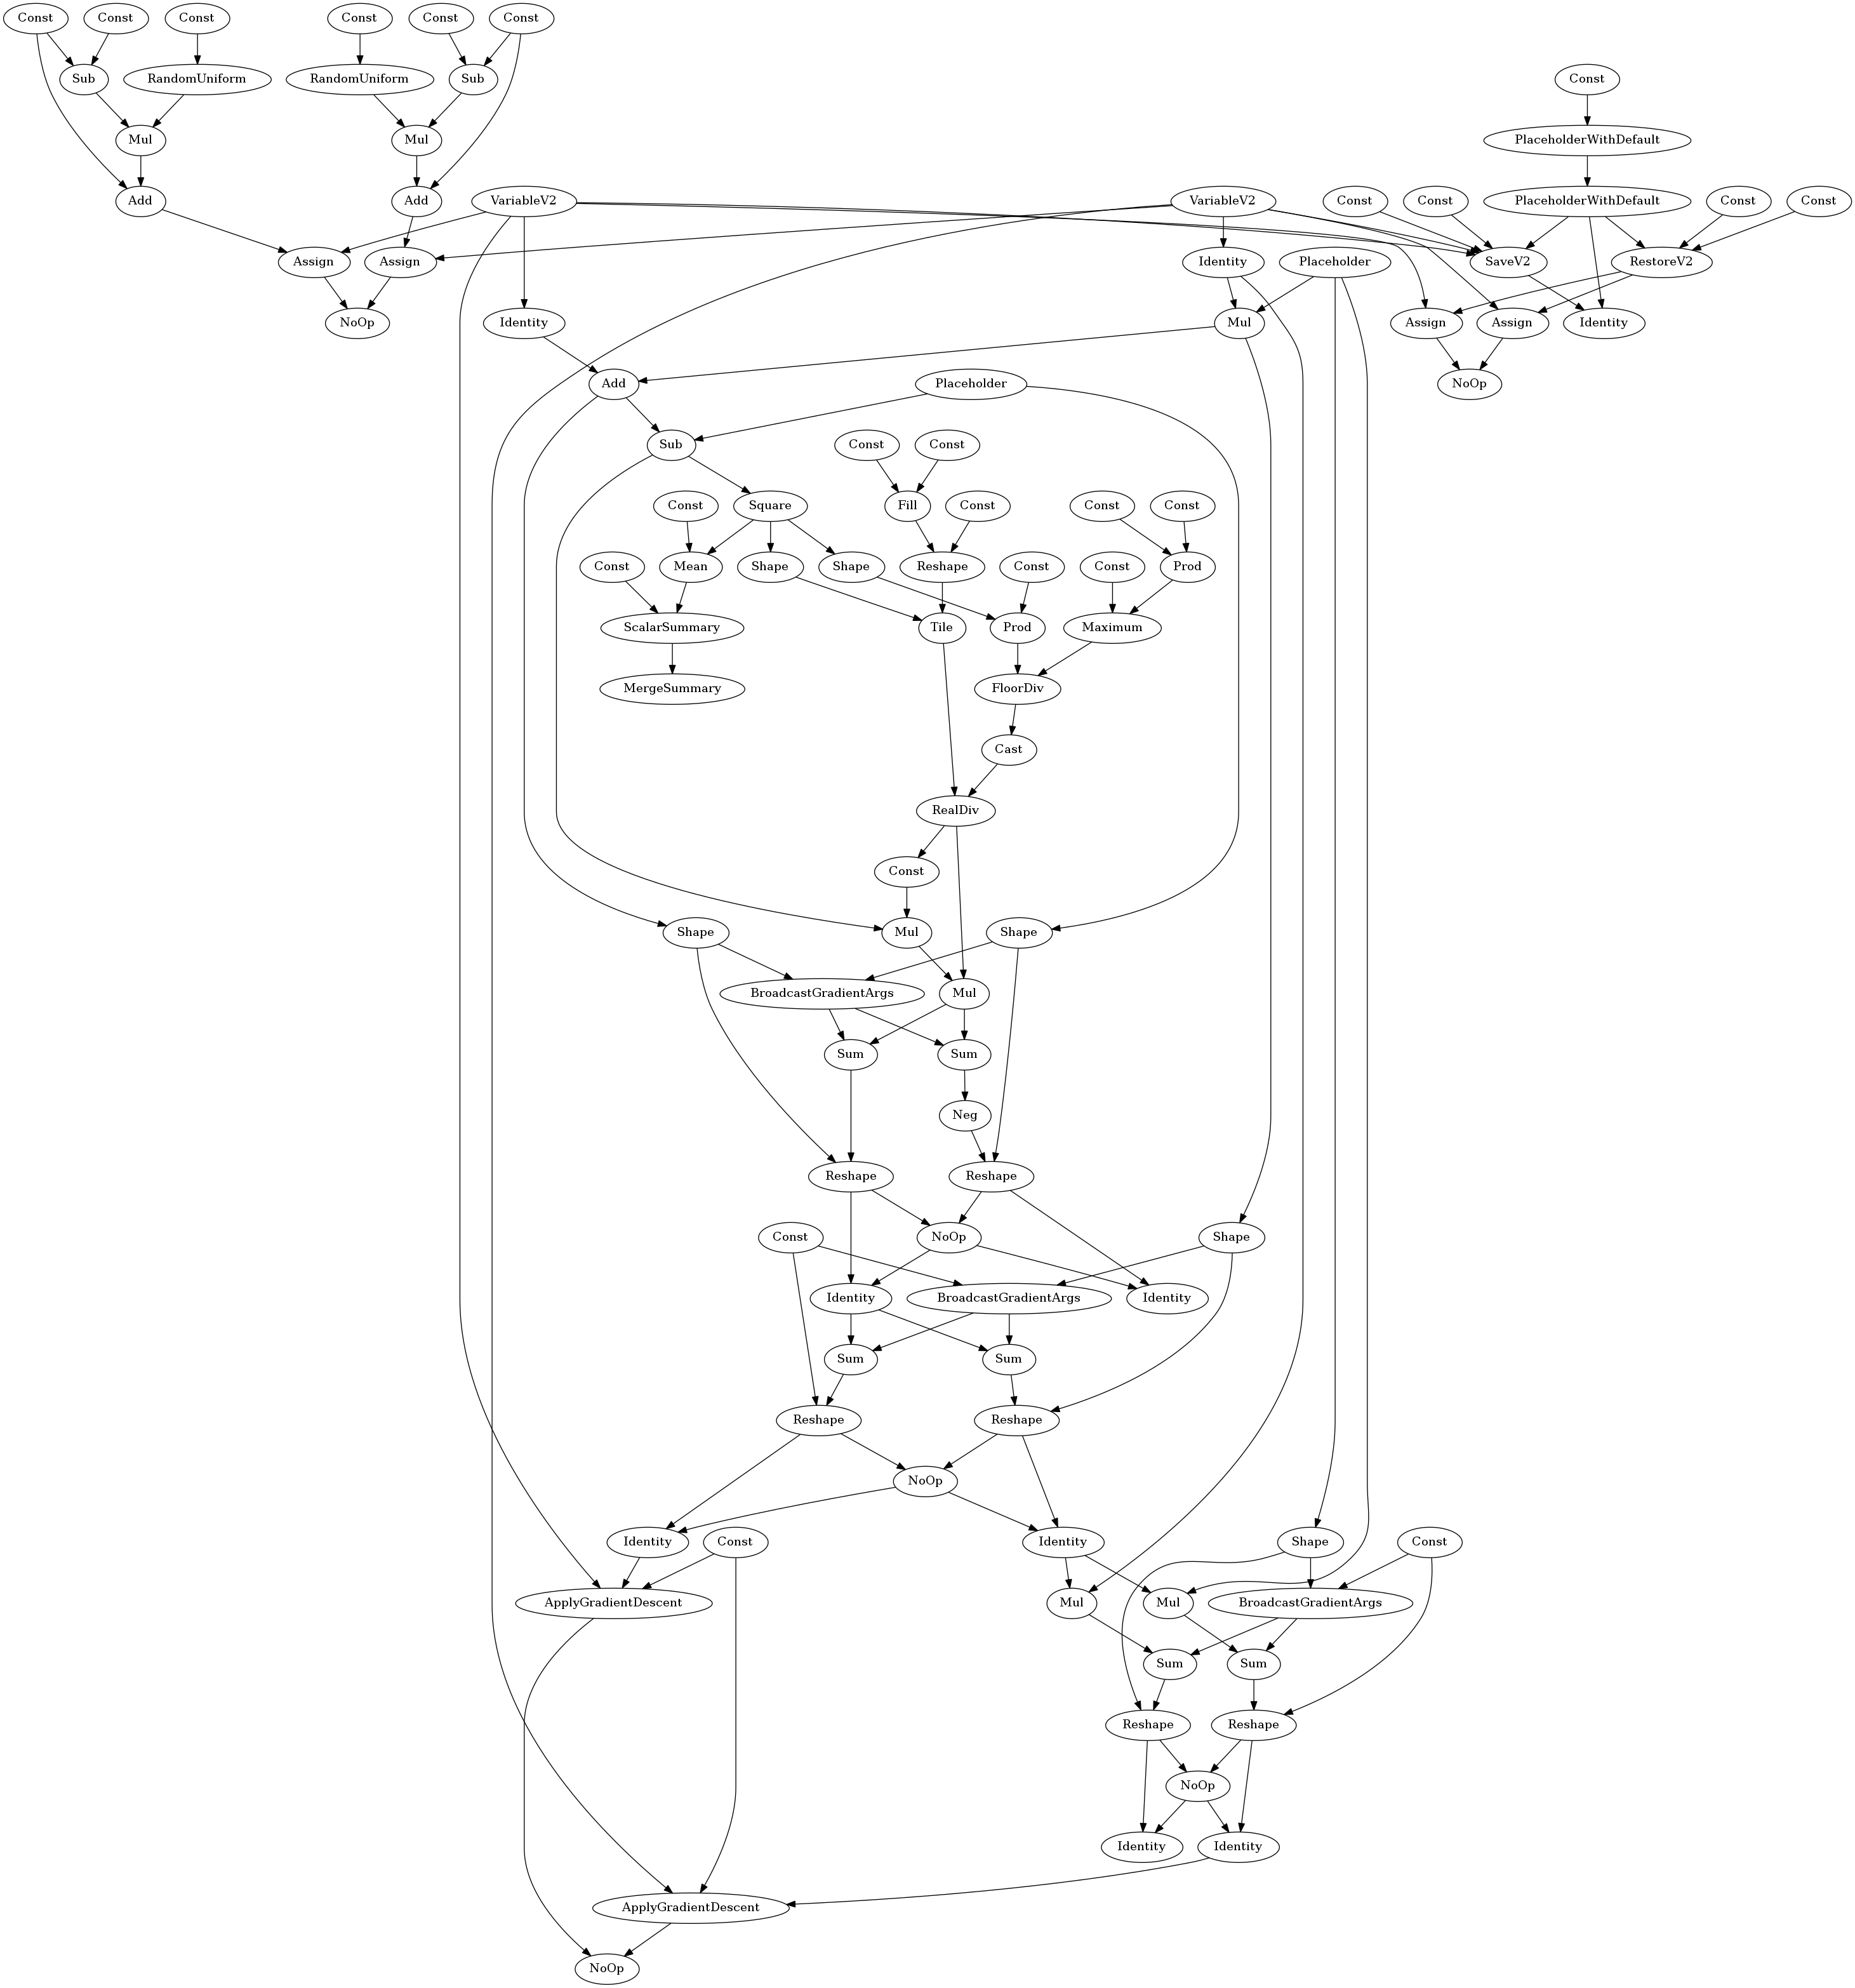

In [23]:
from IPython.display import Image

Image('./graph_cpu.png', width=1024, height=768)

# Prepare Optimized Model for Deployment

## Freeze Fully Optimized Graph

In [24]:
from tensorflow.python.tools import freeze_graph

model_parent_path = './linear_model/cpu/checkpoint'

model_graph_path = '%s/graph.pb' % model_parent_path
frozen_model_graph_path = '%s/frozen_model_graph_cpu.pb' % model_parent_path
model_checkpoint_path = '%s/model.ckpt' % model_parent_path

freeze_graph.freeze_graph(input_graph=model_graph_path, 
                          input_saver="",
                          input_binary=True, 
                          input_checkpoint=model_checkpoint_path,
                          output_node_names="add",
                          restore_op_name="save/restore_all", 
                          filename_tensor_name="save/Const:0",
                          output_graph=frozen_model_graph_path, 
                          clear_devices=True, 
                          initializer_nodes="")
print(frozen_model_graph_path)

Instructions for updating:
Use tf.gfile.GFile.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./linear_model/cpu/checkpoint/model.ckpt
Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.
./linear_model/cpu/checkpoint/frozen_model_graph_cpu.pb


In [25]:
%%bash

ls -l ./linear_model/cpu/checkpoint/

total 48
-rw-r--r-- 1 root users    77 Aug 23 00:28 checkpoint
-rw-r--r-- 1 root users   392 Aug 23 00:29 frozen_model_graph_cpu.pb
-rw-r--r-- 1 root users 12256 Aug 23 00:28 graph.pb
-rw-r--r-- 1 root users     8 Aug 23 00:28 model.ckpt.data-00000-of-00001
-rw-r--r-- 1 root users   143 Aug 23 00:28 model.ckpt.index
-rw-r--r-- 1 root users 18130 Aug 23 00:28 model.ckpt.meta


In [26]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import re
from google.protobuf import text_format
from tensorflow.core.framework import graph_pb2

def convert_graph_to_dot(input_graph, output_dot, is_input_graph_binary):
    graph = graph_pb2.GraphDef()
    with open(input_graph, "rb") as fh:
        if is_input_graph_binary:
            graph.ParseFromString(fh.read())
        else:
            text_format.Merge(fh.read(), graph)
    with open(output_dot, "wt") as fh:
        print("digraph graphname {", file=fh)
        for node in graph.node:
            output_name = node.name
            print("  \"" + output_name + "\" [label=\"" + node.op + "\"];", file=fh)
            for input_full_name in node.input:
                parts = input_full_name.split(":")
                input_name = re.sub(r"^\^", "", parts[0])
                print("  \"" + input_name + "\" -> \"" + output_name + "\";", file=fh)
        print("}", file=fh)
        print("Created dot file '%s' for graph '%s'." % (output_dot, input_graph))
        

In [27]:
input_graph='./linear_model/cpu/checkpoint/frozen_model_graph_cpu.pb'
output_dot='./frozen_model_graph_cpu.dot'
convert_graph_to_dot(input_graph=input_graph, output_dot=output_dot, is_input_graph_binary=True)

Created dot file './frozen_model_graph_cpu.dot' for graph './linear_model/cpu/checkpoint/frozen_model_graph_cpu.pb'.


In [28]:
%%bash

dot -T png ./frozen_model_graph_cpu.dot \
    -o ./frozen_model_graph_cpu.png > b.out

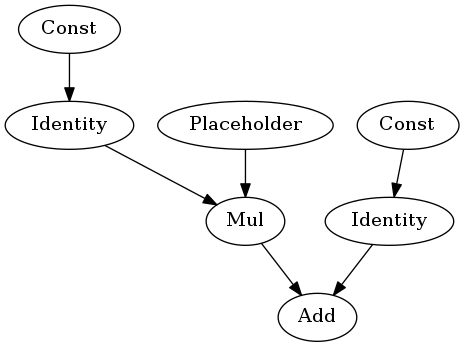

In [29]:
from IPython.display import Image

Image('./frozen_model_graph_cpu.png')

# Save Model for Deployment and Inference

## Reset Default Graph

In [30]:
import tensorflow as tf

tf.reset_default_graph()

## Create New Session

In [31]:
sess = tf.Session()

## Load Frozen Graph

In [32]:
from tensorflow.python.tools import inspect_checkpoint

inspect_checkpoint.print_tensors_in_checkpoint_file(file_name="./linear_model/cpu/checkpoint/model.ckpt",
                                                    tensor_name="",
                                                    all_tensors=True,
                                                    all_tensor_names=True)

tensor_name:  bias
0.38842008
tensor_name:  weights
-0.065062106


In [33]:
saver = tf.train.import_meta_graph('./linear_model/cpu/checkpoint/model.ckpt.meta')
saver.restore(sess, './linear_model/cpu/checkpoint/model.ckpt')

model_parent_path = './linear_model/cpu/checkpoint/'
frozen_model_graph_path = '%s/frozen_model_graph_cpu.pb' % model_parent_path
print(frozen_model_graph_path)

with tf.gfile.GFile(frozen_model_graph_path, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

tf.import_graph_def(
    graph_def, 
    input_map=None, 
    return_elements=None, 
    name="", 
    op_dict=None, 
    producer_op_list=None
)

print("weights = ", sess.run("weights:0"))
print("bias = ", sess.run("bias:0"))

INFO:tensorflow:Restoring parameters from ./linear_model/cpu/checkpoint/model.ckpt
./linear_model/cpu/checkpoint//frozen_model_graph_cpu.pb
Instructions for updating:
Please file an issue at https://github.com/tensorflow/tensorflow/issues if you depend on this feature.
weights =  -0.065062106
bias =  0.38842008


## Create `SignatureDef` Asset for TensorFlow Serving

In [34]:
from tensorflow.python.saved_model import utils
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils

graph = tf.get_default_graph()

x_observed = graph.get_tensor_by_name('x_observed:0')
y_pred = graph.get_tensor_by_name('add:0')

inputs_map = {'inputs': x_observed}
outputs_map = {'outputs': y_pred}

predict_signature = signature_def_utils.predict_signature_def(
                inputs = inputs_map, 
                outputs = outputs_map)
print(predict_signature)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
inputs {
  key: "inputs"
  value {
    name: "x_observed:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
outputs {
  key: "outputs"
  value {
    name: "add:0"
    dtype: DT_FLOAT
    tensor_shape {
      dim {
        size: -1
      }
    }
  }
}
method_name: "tensorflow/serving/predict"



## Save Model with Assets

In [35]:
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import tag_constants
from shutil import rmtree
from tensorflow.contrib import predictor
import numpy as np
import os

saved_model_path = './linear_model/cpu/pipeline_tfserving/0'

os.makedirs(saved_model_path, exist_ok=True)
rmtree(saved_model_path)

import tensorflow.saved_model as saved_model
from shutil import rmtree

saved_model.simple_save(sess,
            saved_model_path,
            inputs={'inputs': x_observed},
            outputs={"outputs": y_pred})

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.simple_save.
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./linear_model/cpu/pipeline_tfserving/0/saved_model.pb


In [36]:
import os
print(saved_model_path)
os.listdir(saved_model_path)
os.listdir('%s/variables' % saved_model_path)

./linear_model/cpu/pipeline_tfserving/0


['variables.data-00000-of-00001', 'variables.index']

In [37]:
%%bash
echo "./linear_model/cpu/pipeline_tfserving/0"
echo ""
ls -al ./linear_model/cpu/pipeline_tfserving/0

./linear_model/cpu/pipeline_tfserving/0

total 36
drwxr-sr-x 3 root users  4096 Aug 23 00:29 .
drwxr-sr-x 3 root users  4096 Aug 23 00:29 ..
-rw-r--r-- 1 root users 20655 Aug 23 00:29 saved_model.pb
drwxr-sr-x 2 root users  4096 Aug 23 00:29 variables


## Inspect with [Saved Model CLI](https://www.tensorflow.org/guide/saved_model)
Note:  This takes a minute or two for some reason.  Please be patient.

In [38]:
import subprocess

output = subprocess.run(["saved_model_cli", "show", \
                "--dir", saved_model_path, "--all"], \
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE)

print(output.stdout.decode('utf-8'))


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['inputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: x_observed:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['outputs'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1)
        name: add:0
  Method name is: tensorflow/serving/predict



# Optimized Model for Deployment

## Predict with Python (SLOW)


In [39]:
from tensorflow.contrib import predictor
import numpy as np

saved_model_path = './linear_model/cpu/pipeline_tfserving/0'
print(saved_model_path)

input_shape = 1
input_data = np.random.random_sample(input_shape)

predict_fn = predictor.from_saved_model(saved_model_path)

./linear_model/cpu/pipeline_tfserving/0
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./linear_model/cpu/pipeline_tfserving/0/variables/variables


In [40]:
%%time
predictions = predict_fn({'inputs': input_data})

print('Prediction: %s' % predictions["outputs"])

Prediction: [0.33197308]
CPU times: user 4.96 ms, sys: 119 µs, total: 5.08 ms
Wall time: 4 ms


## Optimize with TensorFlow Lite

![PipelineAI + TensorFlow Lite](./img/toco-optimizer.png)

In [41]:
import tensorflow as tf
import os

from shutil import rmtree

saved_model_path = './linear_model/cpu/pipeline_tfserving/0'
print(saved_model_path)

tflite_model_base_path = './linear_model/cpu/tflite/'

os.makedirs(tflite_model_base_path, exist_ok=True)

converter = tf.lite.TocoConverter.from_saved_model(saved_model_path)

# TF 1.11+
converter.post_training_quantize = True

tflite_model = converter.convert()

tflite_model_path = '%s/tflite_optimized_model.tflite' % tflite_model_base_path

model_size = open(tflite_model_path, "wb").write(tflite_model)

print('\nModel size reduced to %s bytes' % model_size)

./linear_model/cpu/pipeline_tfserving/0
Instructions for updating:
Use `lite.TFLiteConverter.from_saved_model` instead.
INFO:tensorflow:Restoring parameters from ./linear_model/cpu/pipeline_tfserving/0/variables/variables
INFO:tensorflow:The given SavedModel MetaGraphDef contains SignatureDefs with the following keys: {'serving_default'}
INFO:tensorflow:input tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: inputs
INFO:tensorflow: tensor name: x_observed:0, shape: (-1), type: DT_FLOAT
INFO:tensorflow:output tensors info: 
INFO:tensorflow:Tensor's key in saved_model's tensor_map: outputs
INFO:tensorflow: tensor name: add:0, shape: (-1), type: DT_FLOAT
INFO:tensorflow:Restoring parameters from ./linear_model/cpu/pipeline_tfserving/0/variables/variables
INFO:tensorflow:Froze 2 variables.
INFO:tensorflow:Converted 2 variables to const ops.

Model size reduced to 656 bytes


In [42]:
%%bash -s "$tflite_model_path"
echo "ls -al $1"
echo ""
ls -al $1

ls -al ./linear_model/cpu/tflite//tflite_optimized_model.tflite

-rw-r--r-- 1 root users 656 Aug 23 00:29 ./linear_model/cpu/tflite//tflite_optimized_model.tflite


In [43]:
import numpy as np
import tensorflow as tf

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

In [44]:
# Get input and output tensors.
input_details = interpreter.get_input_details()
print('Input Tensor Details: %s' % input_details)

output_details = interpreter.get_output_details()
print('Output Tensor Details: %s' % output_details)

Input Tensor Details: [{'name': 'x_observed', 'index': 4, 'shape': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]
Output Tensor Details: [{'name': 'add', 'index': 0, 'shape': array([1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0)}]


In [45]:
# Test model on random input data.
input_shape = input_details[0]['shape']
input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
print('Input: %s' % input_data)
interpreter.set_tensor(input_details[0]['index'], input_data)

Input: [0.25449297]


In [46]:
%%time
interpreter.invoke()

CPU times: user 11 µs, sys: 1e+03 ns, total: 12 µs
Wall time: 15.3 µs


In [47]:
output_data = interpreter.get_tensor(output_details[0]['index'])
print('Prediction: %s' % output_data)

Prediction: [0.37186223]
